In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_add_pool
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import HuberLoss
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from torch_geometric.nn import GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.data import Data, Dataset
from torch.optim import AdamW
from tqdm import tqdm
from rdkit import Chem
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
print(device)
mm = MinMaxScaler()

log_transformer = FunctionTransformer(np.log1p, validate=True)
log_minmax_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])

cuda:0


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. 원자·본드 피처 헬퍼
# ─────────────────────────────────────────────────────────────────────────────
ATOM_LIST = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]                 # H C N O F P S Cl Br I
NUM_ATOMS = len(ATOM_LIST) + 1                                  # +1 for "other"

BOND_TYPES = [Chem.rdchem.BondType.SINGLE,
              Chem.rdchem.BondType.DOUBLE,
              Chem.rdchem.BondType.TRIPLE,
              Chem.rdchem.BondType.AROMATIC]                    # 4 종류
EDGE_DIM = 6                                                    # 4 + conjugated + in_ring

def atom_features(atom: Chem.Atom) -> torch.Tensor:
    """길이 15: 10(one-hot) + degree(0-4) + aromatic + formal_charge"""
    Z = atom.GetAtomicNum()
    one_hot = [int(Z == a) for a in ATOM_LIST] + [int(Z not in ATOM_LIST)]
    degree  = [int(atom.GetTotalDegree() == d) for d in range(5)]          # 0~4
    aromatic = [int(atom.GetIsAromatic())]
    charge   = [atom.GetFormalCharge() + 3]                                # −3~+3 → 0~6
    charge_oh = [int(charge[0] == c) for c in range(7)]                    # 7 bins
    return torch.tensor(one_hot + degree + aromatic + charge_oh, dtype=torch.float)

def bond_features(bond: Chem.Bond) -> torch.Tensor:
    btype = [int(bond.GetBondType() == t) for t in BOND_TYPES]            # 4
    conj  = [int(bond.GetIsConjugated())]                                 # 1
    ring  = [int(bond.IsInRing())]                                        # 1
    return torch.tensor(btype + conj + ring, dtype=torch.float)           # (6,)

# ─────────────────────────────────────────────────────────────────────────────
# 2. 데이터셋
# ─────────────────────────────────────────────────────────────────────────────
class PolymerDatasetPyG(Dataset):
    """
    csv:
        col1: ID    col2: SMILES    ... col5: DP    ... col7: conductivity
    """
    def __init__(self, csv_path: str):
        super().__init__()
        df = pd.read_csv(csv_path)

        # ── 2-1. 그래프-레벨 스칼라 (DP) ────────────────────────
        dp_raw = df.iloc[:, 4].values.reshape(-1, 1)           # (N,1)
        self.dp = torch.tensor(mm.fit_transform(dp_raw),
                               dtype=torch.float32).squeeze(1) # (N,)

        # (선택) 추가 물성 스칼라 예: conductivity
        self.cond = torch.tensor(
            log_minmax_pipeline.fit_transform(
                df.iloc[:, 6].values.reshape(-1, 1)),
            dtype=torch.float32
        ).squeeze(1)                                           # (N,)

        # ── 2-2. 그래프 생성 ──────────────────────────────────
        self.graphs = []
        for i, smi in enumerate(df.iloc[:, 1]):
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                raise ValueError(f"SMILES parse error: {smi}")

            # 원자 피처
            x = torch.stack([atom_features(a) for a in mol.GetAtoms()])    # (num_nodes, 15)

            # 엣지 (양방향)
            edge_index = []
            edge_attr  = []
            for bond in mol.GetBonds():
                u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                feat  = bond_features(bond)
                # 양방향 추가
                edge_index.extend([[u, v], [v, u]])
                edge_attr.extend([feat, feat.clone()])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t()    # (2, E)
            edge_attr  = torch.stack(edge_attr)                            # (E, 6)

            data = Data(x=x,
                        edge_index=edge_index,
                        edge_attr=edge_attr,
                        dp=self.dp[i].view(1),       # (1,)
                        cond=self.cond[i].view(1),   # (1,)
                        y=torch.zeros(1))            # placeholder; 채워 넣으세요
            self.graphs.append(data)

    # -----------------------------------------------------------------------
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [3]:
Polymers = "simulation-trajectory-aggregate_aligned.csv"
dataset = PolymerDatasetPyG(Polymers)

train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=False)

In [4]:
class PolyGNNRegressor(nn.Module):
    """
    단일 물성 회귀를 위한 polyGNN variant.

    Args
    ----
    node_dim   : 노드(feature) 차원
    edge_dim   : 엣지(feature) 차원
    hidden_dim : 메시지 패싱 임베딩 차원
    num_layers : GINEConv 층 수
    """
    def __init__(self, node_dim, edge_dim, hidden_dim=256, num_layers=6):
        super().__init__()

        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()

        for i in range(num_layers):
            in_dim = node_dim if i == 0 else hidden_dim

            # GINEConv: edge_attr (연결 원자쌍 종류, 본드 차수 등) 활용
            mlp = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
            )
            self.convs.append(GINEConv(mlp, edge_dim=edge_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))

        # 그래프-수준 집계: additive pooling(논문 기본 설정)
        self.pool = global_add_pool

        # DP(1차원)까지 포함 → hidden_dim+1 → 1
        self.head = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        # data.x          : (total_nodes, node_dim)
        # data.edge_attr  : (total_edges, edge_dim)
        # data.dp         : (batch_size,)  – 정규화된 스칼라
        x, edge_index, edge_attr, batch = \
            data.x, data.edge_index, data.edge_attr, data.batch

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_attr)   # message passing
            x = bn(x)
            x = F.relu(x)

        g = self.pool(x, batch)                 # (B, hidden_dim)

        dp = data.dp.float().view(-1, 1)        # (B, 1)
        g  = torch.cat([g, dp], dim=1)          # (B, hidden_dim+1)

        return self.head(g).squeeze(1)          # (B,)

In [5]:
model = PolyGNNRegressor(node_dim=24, edge_dim=6)
model.cuda()
lr=1e-3
optim = AdamW(model.parameters(), lr=lr)
loss_fn = HuberLoss()

In [6]:
model.train()
epoch = 1000
progress = tqdm(range(epoch), desc="Training")

loss_arr = []

for i in progress:
    batchloss = 0.0
    for batch in train_dataloader:
        batch = batch.to(device)
        optim.zero_grad()

        pred = model(batch)
        
        loss = loss_fn(pred, batch.cond)
        
        loss.backward()
        optim.step()
        batchloss += loss
        
    loss_arr.append((batchloss.cpu().item() / len(train_dataloader)))
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))

loss: 0.000154:  36%|███▌      | 356/1000 [01:59<03:36,  2.98it/s]


KeyboardInterrupt: 

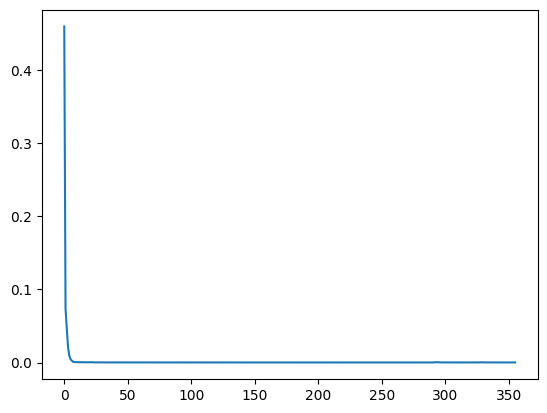

In [7]:
plt.plot(loss_arr, label="loss")

In [8]:
test_data = "gen.csv"
test_dataset = PolymerDatasetPyG(test_data)

test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)
conds = torch.Tensor(0)

with torch.no_grad():
    for batch in test_dataloader:
        cond = model(batch.to(device))
        conds = torch.cat((conds,cond.cpu().view(-1)),axis=0)
conds = conds.detach().cpu().numpy()
conds = log_minmax_pipeline.inverse_transform(conds.reshape(-1, 1))
print(conds)
print(max(conds))
print(conds.shape)

[[1.18334894e-04]
 [4.88385151e-04]
 [9.42956685e-05]
 [9.54922070e-05]
 [5.43740345e-04]
 [1.15239585e-03]
 [2.48680299e-04]
 [9.91514607e-05]
 [1.10393892e-04]
 [9.68728491e-05]
 [1.24421422e-04]
 [1.08589098e-04]
 [9.23440384e-05]
 [1.19476288e-04]
 [8.91375603e-05]
 [8.48892741e-05]
 [6.68386638e-05]
 [3.49691691e-04]
 [9.59757832e-04]
 [3.14180594e-04]
 [1.04483159e-04]
 [8.74101897e-05]
 [2.01779476e-04]
 [1.80478572e-04]
 [1.01828162e-04]
 [9.28002046e-05]
 [1.02626022e-04]
 [3.35840246e-04]
 [1.19602373e-04]
 [2.05383854e-04]
 [3.26929672e-04]
 [8.98226208e-05]
 [2.29451500e-04]
 [9.79043325e-05]
 [1.02332589e-04]
 [8.03341973e-05]
 [1.64782818e-04]
 [1.07598345e-04]
 [7.33329434e-05]
 [7.32362314e-05]
 [5.81005042e-05]
 [9.17953221e-05]
 [1.06048530e-04]
 [4.95226472e-04]
 [3.08270392e-04]
 [7.98612076e-04]
 [1.00990721e-04]
 [2.25868338e-04]
 [1.21513396e-04]
 [8.60869986e-05]
 [9.63056591e-05]
 [9.91753623e-05]
 [3.39461782e-04]
 [9.29256203e-05]
 [2.68569856e-04]
 [1.080713